<a href="https://colab.research.google.com/github/trabelsi-mohamed-amine/credit-card-fraud-detection-machine-learning/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub
ealaxi_paysim1_path = kagglehub.dataset_download('ealaxi/paysim1')

print('Data source import complete.')


Data source import complete.


# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:140%; font-family:San-Serif; letter-spacing:0.5px;"> <p style="padding: 10px; color:black; text-align:center;">Importing dependencies</p> </div>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Reading CSV</p> </div>

In [ ]:
fraud = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

In [ ]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


> Now we will use the info function to see the datatypes and number of instances in our dataset.

In [ ]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


> Let's use the shape function that returns the shape of our dataset.

In [ ]:
fraud.shape

(6362620, 11)

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Data Cleaning</p> </div>

> It's quite important to have a look at the missing values of the the dataset. We will remove them or interpolate those missing values if we find any. Let's use missingo library function to do this task.

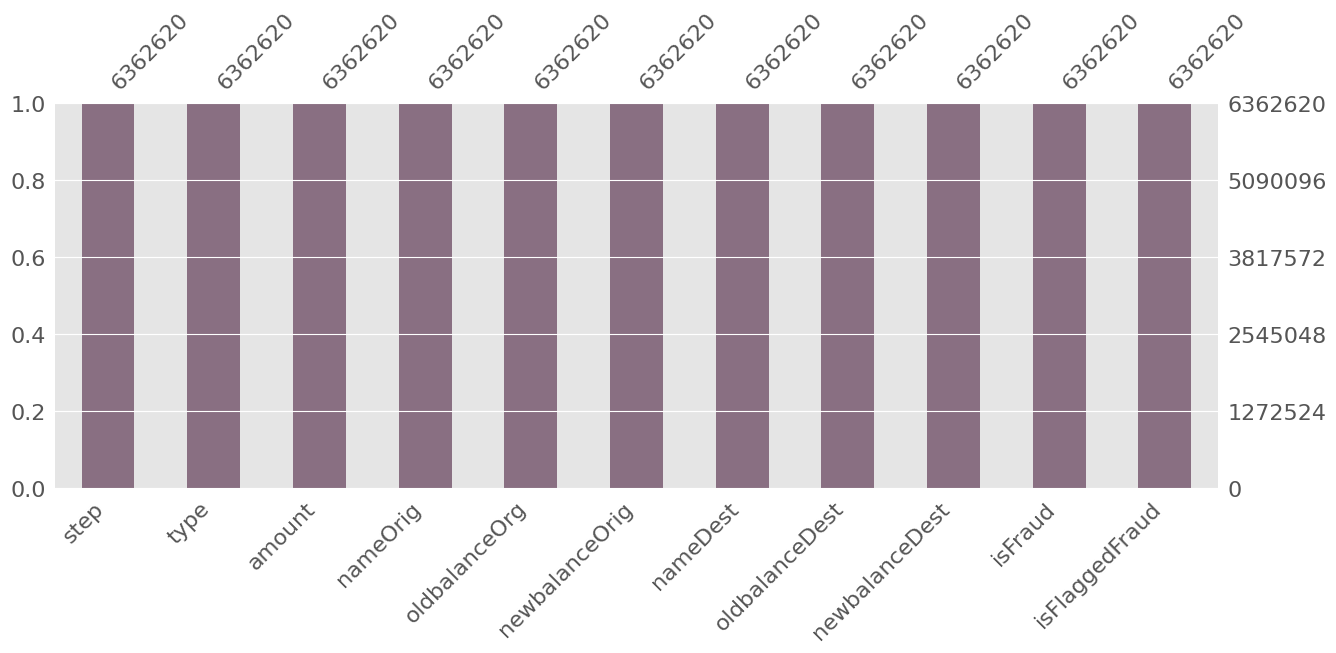

In [ ]:
plt.figure(figsize = (15, 8))
msno.bar(fraud, figsize = (15,5), sort = 'ascending', color = "#896F82")
plt.show()

\> It's time to use the duplication function to make sure if there are any duplicated values in the dataset or not.

In [ ]:
print('Number of duplicates are : ', fraud.duplicated().sum())

Number of duplicates are :  0


> Let's have a look at the column names to see if they need any correction or not. We usually do this to see typo errors.

In [ ]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

> Now, let's rename some of the column names by using rename function.

In [ ]:
fraud = fraud.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})

> It's also good to drop down the non essential columns from a dataset. We will do this with the help of drop function.

In [ ]:
fraud = fraud.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

> Now it's time to move the target column to our desired location in the dataset.

In [ ]:
cols = fraud.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
fraud = fraud[cols]

> By using the head function, let's be assure of the changes we have done so far.

In [ ]:
fraud.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


**Insights**
* First of all we realized that no single column in our dataset had any null values. It means that our dataset was a clean dataset or the missing values were already taken care of.
* Second, we saw that our dataset does not have any duplicate values.
* Then we renamed some of our columns and changed their positions for our comfort and better understanding.

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Exploratory Data Analysis</p> </div>

> Now let's make a barplot to see the fraud and non fraud transactions in different transactions type

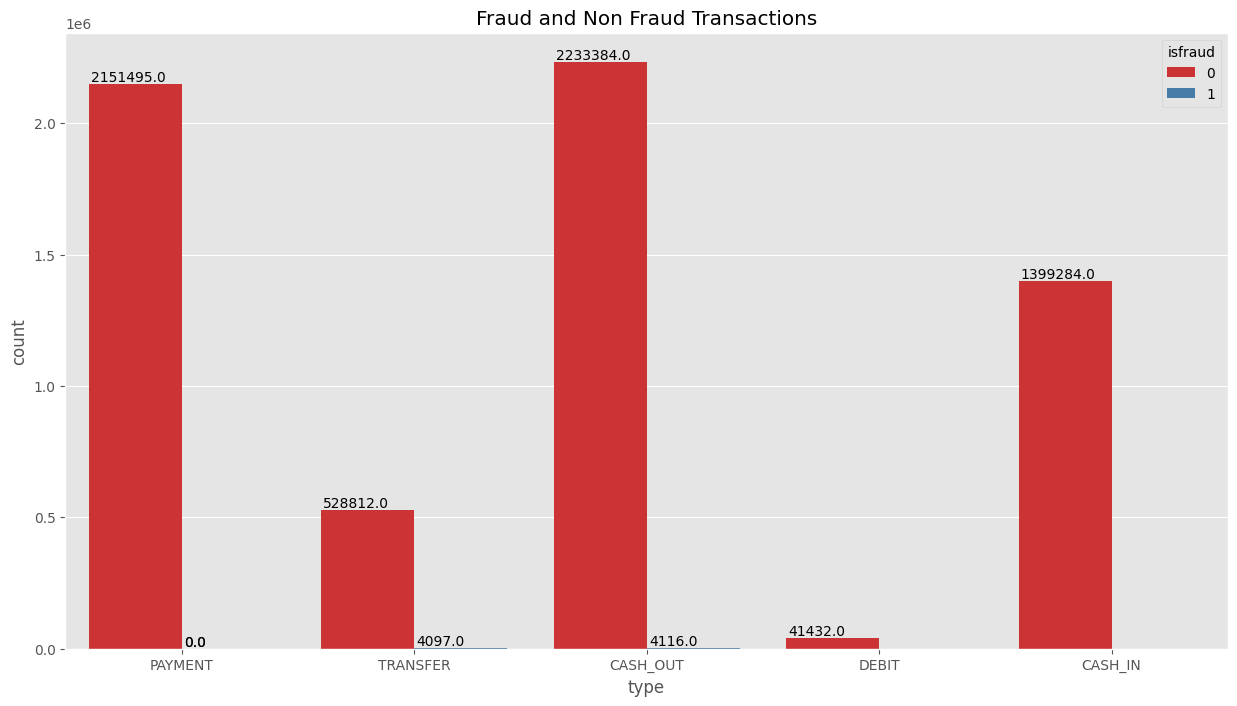

In [ ]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = fraud, x = "type", hue="isfraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

> Checking the origin from where the transactions were made.

In [ ]:
transfer_fraud = fraud[((fraud['type']=='TRANSFER') & fraud['isfraud']==1)]
transfer_fraud['origin'].value_counts()

,count
origin,
C1685995037,1
C1565612524,1
C992223106,1
C1945606464,1
C88849251,1
...,...
C669700766,1
C1364127192,1
C1334405552,1


> Checking the destination from where the transactions were cashed out.

In [ ]:
cash_out_fraud = fraud[(fraud['type'] == 'CASH_OUT') & (fraud['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

,count
destination,
C1650668671,2
C644163395,2
C1013511446,2
C2129197098,2
C185805228,2
...,...
C1955464150,1
C1104137869,1
C377165949,1


> Checking if the transfer and receiving account were same.

In [ ]:
fraud_trans = fraud[fraud['isfraud'] == 1]
valid_trans = fraud[fraud['isfraud'] == 0]

trans_transfer = fraud[fraud['type'] == 'TRANSER']
trans_cashout = fraud[fraud['type'] == 'CASH_OUT']

print('Has the receiving account used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Has the receiving account used for cashing out?


np.False_

**Insights**
* Our fraud transactions are done in **TRANSFER** and **CASH_OUT** transaction type.
* The fraud transactions in **TRANSFER** were **4097** and **CASH_OUT** were **4116**.
* The **fraud** transactions were generally from **Customer to Customer**
* The transactions account used for **Recieing and Sending was not Same** in case of **Fraud transactions**.

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Feature Engineering</p> </div>

> Now we can do feature engineering to make another column that seems to be helpful for later Machine Learning tasks.

In [ ]:
data = fraud.copy()
data['type2'] = np.nan
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('C'), 'type2'] = 'CC'
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('M'), 'type2'] = 'CM'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MC'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MM'

> Changing the column position for our ease of use.

In [ ]:
cols = data.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
data = data[cols]

> Again, dropping the irrelevant columns.

In [ ]:
data.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

> Using the head function to have a new look of the dataset.

In [ ]:
data.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


> Now we are going to see the number of fraud and valid transactions according to the type 2 that tells if the transaction was done from customer to customer, customer to merchant, merchant to customer or merchant to merchant.

In [ ]:
fraud_trans = data[data['isfraud'] == 1]
valid_trans = data[data['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 type2
CC    8213
Name: count, dtype: int64 

Number of valid transactions according to type are below:
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


**Insights**
* At first, we did some feature engineering and introduced a new column **type2** that contained the type of transaction between **Customers and Merchants**.
* Then, we adjusted the column position and dropped some columns that were no longer of use.
* The number of **Fraud Transactions** in total were **8213** and were made from **Customer to Customer**.
* The number of **Valid Transactions** made from **Customer to Customer** are **4202912**.
* The number of **Valid Transactions** made from **Customer to Merchant** are **2151495**.

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Data Visualization</p> </div>

In [ ]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

Text(0.5, 1.0, 'Valid')

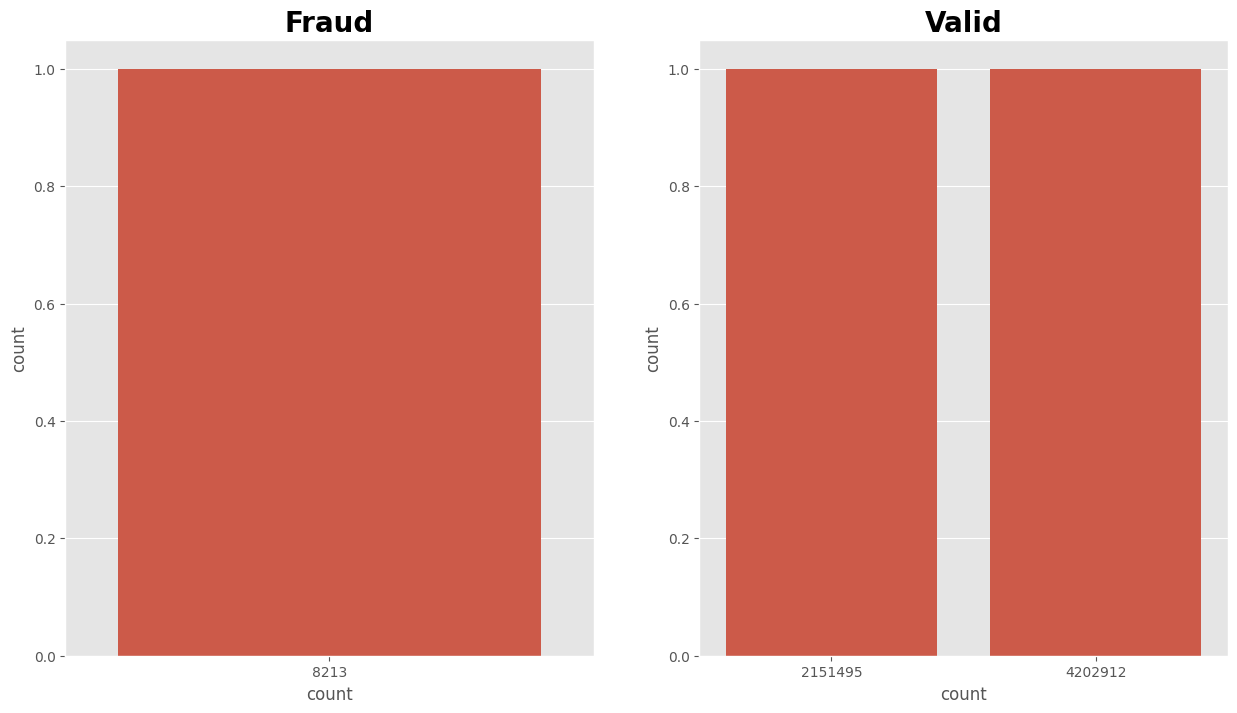

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

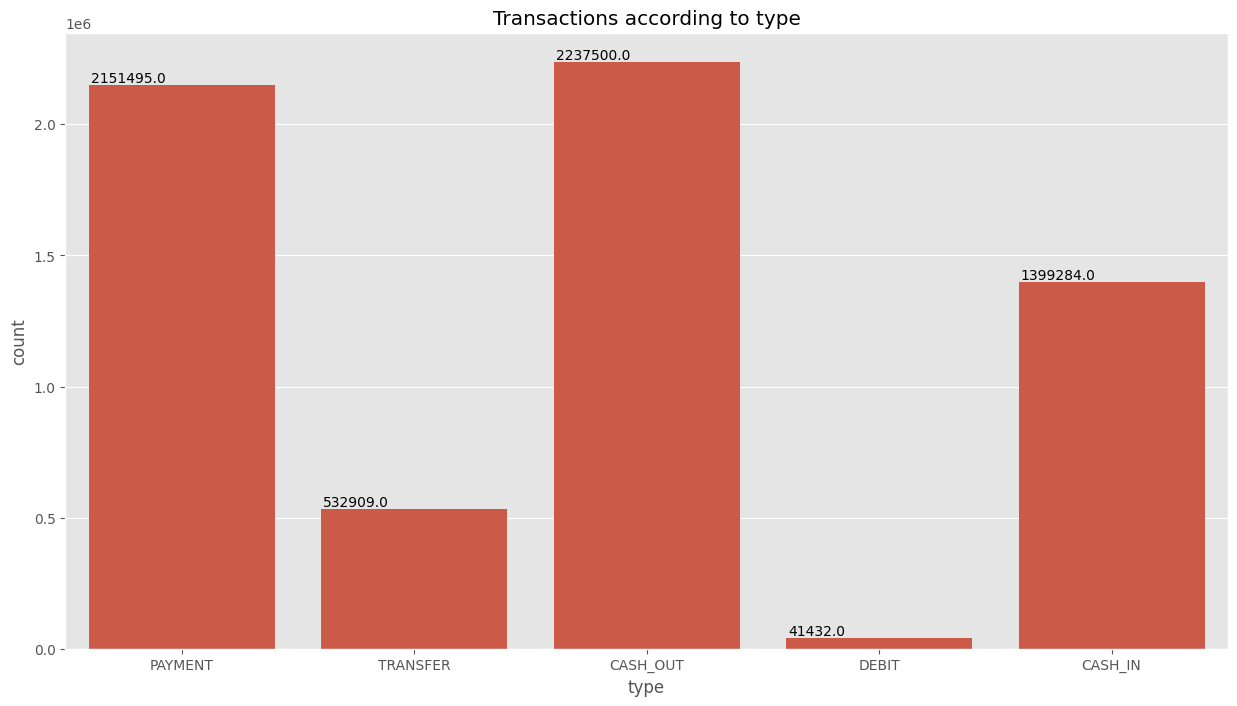

In [ ]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type")
plt.title('Transactions according to type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

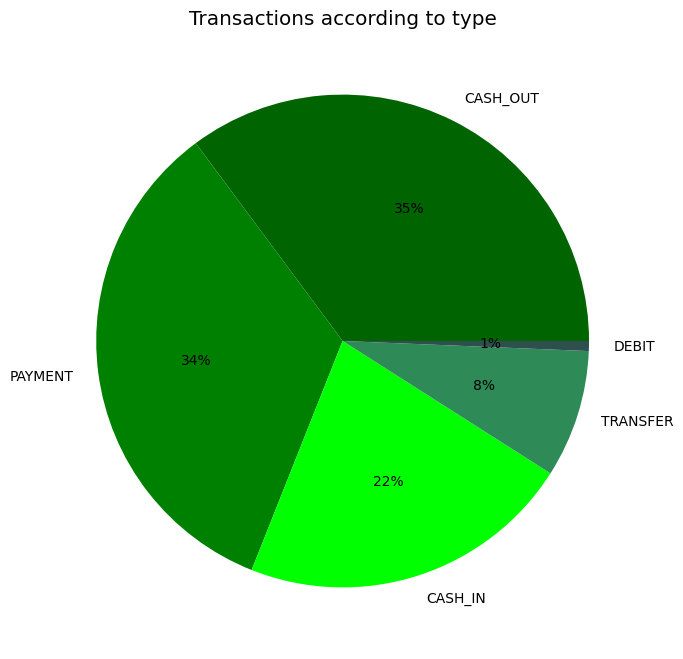

In [ ]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000','#00FF00','#2E8B57','#2F4F4F']
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("Transactions according to type")
plt.show()

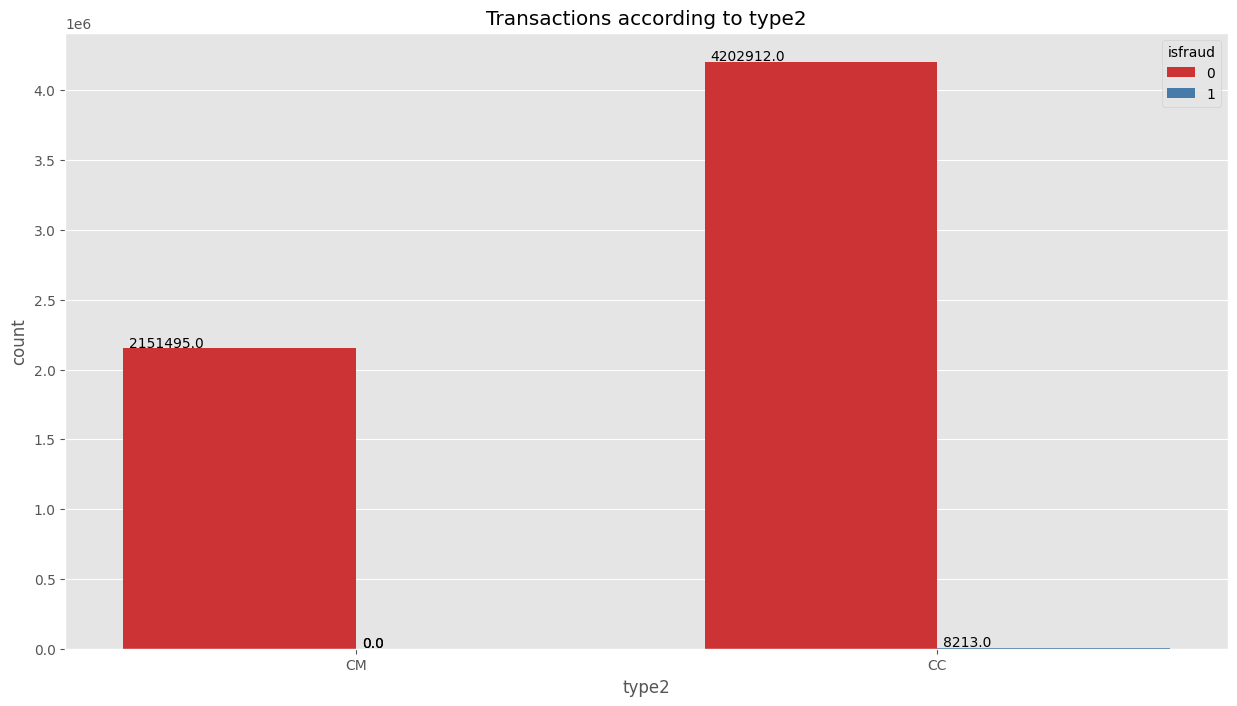

In [ ]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type2", hue="isfraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

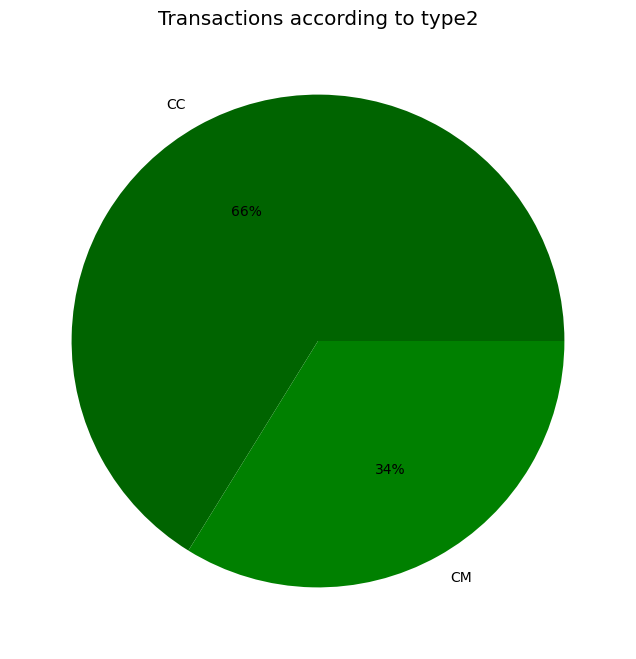

In [ ]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

**Insights**
* The first two visualizations contains the number of transactions according to the type of transaction, sender and reciever type.
* Most common transaction type used for transactions = **CASH_OUT** .
* Least common transaction type used for transactions = **DEBIT**.
* Most of the transactions done were **Customer to Customer** .

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Data Preprocessing</p> </div>

> Let's create the dummies for the later process of Machine Learning. I'll use dummy hot encoding as the columns does not have a specific order.

In [ ]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)

> Now it's time to split the dataset into training and testing part and then do the standardization.

In [ ]:
X = data.drop('isfraud',axis=1)
y = data.isfraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isfraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Model Building</p> </div>

> We will now use 4 ML models and train them. Later we will append each model into the list.

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 10
[LightGBM] [

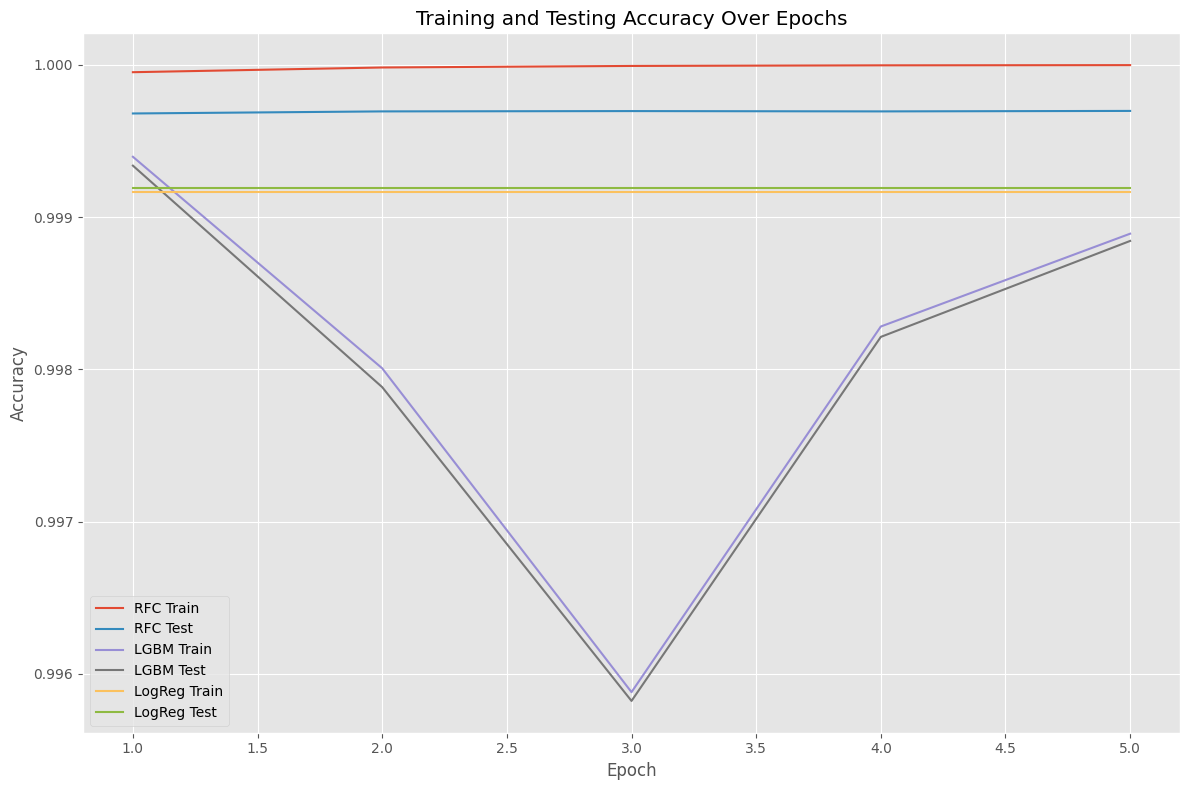

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Containers to hold accuracy over epochs
epochs = 5
rfc_train_acc, rfc_test_acc = [], []
lgbm_train_acc, lgbm_test_acc = [], []
logreg_train_acc, logreg_test_acc = [], []

# RandomForest
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
for epoch in range(1, epochs + 1):
    rfc.set_params(n_estimators=epoch * 10)
    rfc.fit(X_train, y_train)
    rfc_train_acc.append(accuracy_score(y_train, rfc.predict(X_train)))
    rfc_test_acc.append(accuracy_score(y_test, rfc.predict(X_test)))

# LightGBM
lgbm = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=8888)
for epoch in range(1, epochs + 1):
    lgbm.set_params(n_estimators=epoch * 20)
    lgbm.fit(X_train, y_train)
    lgbm_train_acc.append(accuracy_score(y_train, lgbm.predict(X_train)))
    lgbm_test_acc.append(accuracy_score(y_test, lgbm.predict(X_test)))

# Logistic Regression (with warm start)
logreg = LogisticRegression(solver='liblinear', warm_start=True, random_state=42)
for epoch in range(1, epochs + 1):
    logreg.fit(X_train, y_train)
    logreg_train_acc.append(accuracy_score(y_train, logreg.predict(X_train)))
    logreg_test_acc.append(accuracy_score(y_test, logreg.predict(X_test)))

# Plotting all models
plt.figure(figsize=(12, 8))
epoch_range = range(1, epochs + 1)

# Plot for each classifier
plt.plot(epoch_range, rfc_train_acc, label='RFC Train')
plt.plot(epoch_range, rfc_test_acc, label='RFC Test')

plt.plot(epoch_range, lgbm_train_acc, label='LGBM Train')
plt.plot(epoch_range, lgbm_test_acc, label='LGBM Test')

plt.plot(epoch_range, logreg_train_acc, label='LogReg Train')
plt.plot(epoch_range, logreg_test_acc, label='LogReg Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


> Let's do the prediction and find out both Accuracy and Area Under Curve (AUC) of each model.

In [ ]:
accuracy_list = []
auc_list = []

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['Random Forest', 'Light GBM', 'XGBoost','LR'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]

accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))

> Below, i'll just create a functions for the visualization part.

In [ ]:
def px_bar(x,y,text,title,color,color_discrete_sequence):
    return px.bar(x = x, y = y, text = text, title = title, color = color, color_discrete_sequence=color_discrete_sequence)

> Let's call the function to see accuracies of each model.

In [ ]:
fig = px_bar(list(accuracy_dict_sorted.keys()), list(accuracy_dict_sorted.values()), np.round(list(accuracy_dict_sorted.values()),3), 'Accuracy score of each classifiers', list(accuracy_dict_sorted.keys()), px.colors.sequential.matter)
for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

> I'll call the visualization function once again to see the AUC values as well.

In [ ]:
fig = px_bar(list(auc_dict_sorted.keys()), list(auc_dict_sorted.values()), np.round(list(auc_dict_sorted.values()),3), 'AUC score of each classifiers', list(auc_dict_sorted.keys()), px.colors.sequential.matter)

for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

# <div style="display:fill; border-radius:15px; background-color:#FDEE72; font-size:130%; font-family:San-Serif; letter-spacing:0.5px"> <p style="padding: 10px; color:black; text-align:center;">Model Evaluation</p> </div>

> Let's train our best model once again.

In [ ]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]

> Printing out the Classification Report.

In [ ]:
print(classification_report(y_test, rfc_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1906322
       Fraud       0.96      0.80      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.90      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



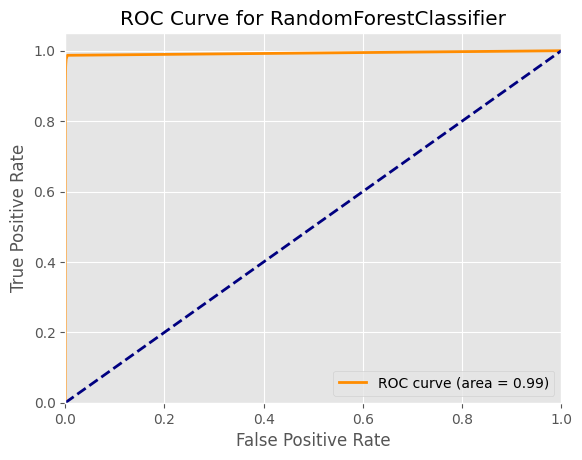

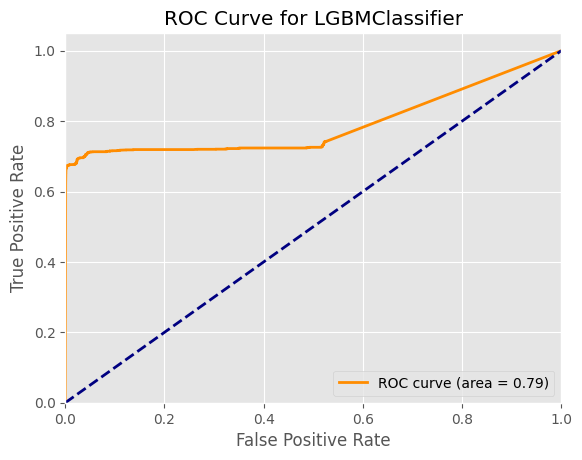

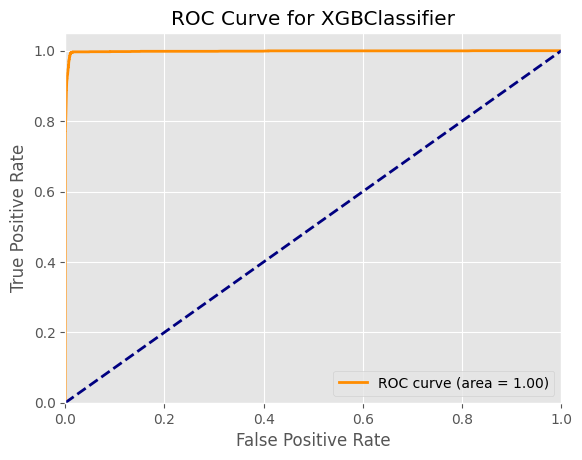

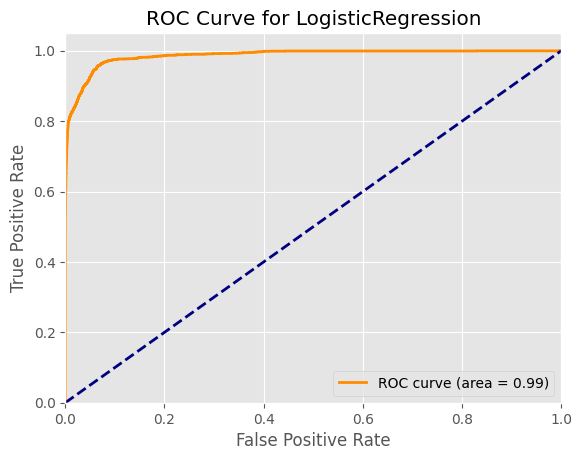

In [ ]:

import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve, auc

for classifier in classifiers:
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {type(classifier).__name__}')
    plt.legend(loc="lower right")
    plt.show()


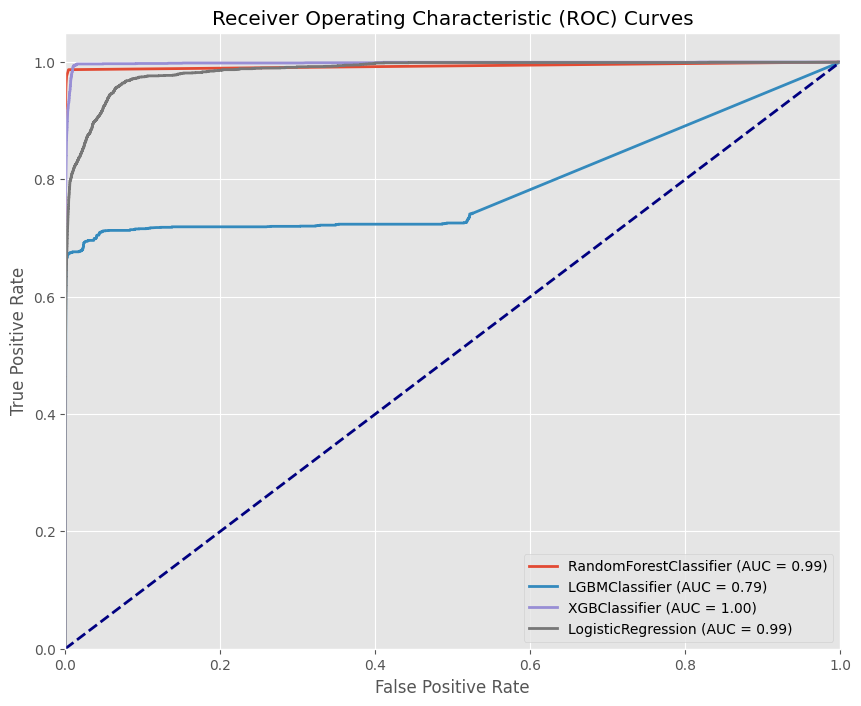

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for classifier in classifiers:
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{type(classifier).__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [ ]:


from sklearn.metrics import accuracy_score, roc_auc_score

for classifier in classifiers:
    # Training performance
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_roc_auc = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])
    print(f"{type(classifier).__name__} - Training Accuracy: {train_accuracy:.4f}, ROC AUC: {train_roc_auc:.4f}")

    # Testing performance
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
    print(f"{type(classifier).__name__} - Testing Accuracy: {test_accuracy:.4f}, ROC AUC: {test_roc_auc:.4f}")

    # Compare training and testing performance
    if abs(train_accuracy - test_accuracy) > 0.1 or abs(train_roc_auc - test_roc_auc) > 0.1 :
      print(f"Model {type(classifier).__name__} might be overfitted.")
    else:
      print(f"Model {type(classifier).__name__} does not appear to be overfitted.")

    print("-" * 20)


RandomForestClassifier - Training Accuracy: 1.0000, ROC AUC: 1.0000
RandomForestClassifier - Testing Accuracy: 0.9997, ROC AUC: 0.9934
Model RandomForestClassifier does not appear to be overfitted.
--------------------
LGBMClassifier - Training Accuracy: 0.9989, ROC AUC: 0.7843
LGBMClassifier - Testing Accuracy: 0.9988, ROC AUC: 0.7902
Model LGBMClassifier does not appear to be overfitted.
--------------------
XGBClassifier - Training Accuracy: 0.9996, ROC AUC: 0.9979
XGBClassifier - Testing Accuracy: 0.9996, ROC AUC: 0.9983
Model XGBClassifier does not appear to be overfitted.
--------------------
LogisticRegression - Training Accuracy: 0.9992, ROC AUC: 0.9833
LogisticRegression - Testing Accuracy: 0.9992, ROC AUC: 0.9862
Model LogisticRegression does not appear to be overfitted.
--------------------
